In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Configuração para exibir os gráficos
%matplotlib inline

# --- 1. Carregamento dos Dados ---
print("Carregando o dataset... (Isso pode demorar um pouco devido ao tamanho do Excel)")

# Ajuste o caminho abaixo se necessário (ex: '../data/online_retail_II.xlsx')
file_path = '../data/online_retail_II.xlsx'

try:
    df_2009 = pd.read_excel(file_path, sheet_name='Year 2009-2010', engine='openpyxl')
    df_2010 = pd.read_excel(file_path, sheet_name='Year 2010-2011', engine='openpyxl')
    df = pd.concat([df_2009, df_2010])
    print("Dados carregados com sucesso!")
except FileNotFoundError:
    print(f"ERRO: Arquivo não encontrado em {file_path}. Verifique se baixou e salvou na pasta correta.")

Carregando o dataset... (Isso pode demorar um pouco devido ao tamanho do Excel)
Dados carregados com sucesso!


In [4]:
# --- 2. Análise Inicial e Limpeza ---
print(f"Tamanho original do dataset: {df.shape}")

# Criar coluna de Faturamento Total (Quantidade * Preço)
df['TotalAmount'] = df['Quantity'] * df['Price']

df_clean = df[~df['Invoice'].astype(str).str.contains('C', na=False)]
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean = df_clean[df_clean['Price'] > 0]

print(f"Tamanho após limpeza (remoção de cancelamentos/devoluções): {df_clean.shape}")

Tamanho original do dataset: (1067371, 8)
Tamanho após limpeza (remoção de cancelamentos/devoluções): (1041670, 9)


C:\Users\Igoro\AppData\Local\Temp\ipykernel_14464\2549520454.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_clean.set_index('InvoiceDate').resample('M')['TotalAmount'].sum().reset_index()


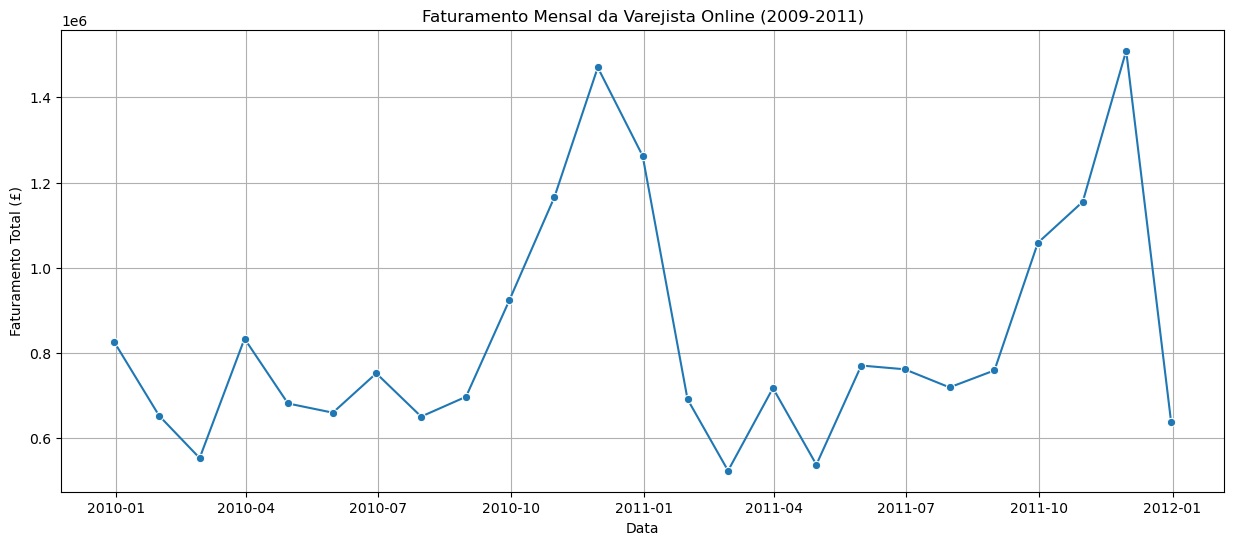

,InvoiceDate,TotalAmount
0,2009-12-31,825685.760
1,2010-01-31,652708.502
2,2010-02-28,553339.736
3,2010-03-31,833570.131
4,2010-04-30,681528.992


In [5]:
# --- 3. Transformação em Série Temporal ---
# Vamos agrupar as vendas por MÊS para ver a tendência de faturamento.
# Converter InvoiceDate para datetime se não estiver
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Criar o dataset mensal
# 'M' significa agrupar pelo fim do mês e somar o 'TotalAmount'
df_monthly = df_clean.set_index('InvoiceDate').resample('M')['TotalAmount'].sum().reset_index()

# Visualizar a Série Temporal
plt.figure(figsize=(15, 6))
sns.lineplot(x='InvoiceDate', y='TotalAmount', data=df_monthly, marker='o')
plt.title('Faturamento Mensal da Varejista Online (2009-2011)')
plt.xlabel('Data')
plt.ylabel('Faturamento Total (£)')
plt.grid(True)
plt.show()

# Exibir as primeiras linhas da série temporal preparada
display(df_monthly.head())

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. Divisão Treino e Teste (Cronológica) ---
if df_monthly.index.name == 'InvoiceDate':
    df_monthly = df_monthly.reset_index()

train_size = int(len(df_monthly) - 6)

train_data = df_monthly.iloc[:train_size].copy()
test_data = df_monthly.iloc[train_size:].copy()

print(f"Meses de Treinamento: {len(train_data)}")
print(f"Meses de Teste: {len(test_data)}")

Meses de Treinamento: 19
Meses de Teste: 6


In [17]:
# --- 2. Criação e Treinamento do Modelo ---
train_data = train_data.set_index('InvoiceDate')
test_data = test_data.set_index('InvoiceDate')

# Ajuste de frequência
try:
    train_data.index.freq = 'ME'
    test_data.index.freq = 'ME'
except:
    train_data.index.freq = 'M'
    test_data.index.freq = 'M'


# Removi seasonal='add' e seasonal_periods=12.
# Agora usei apenas Trend (Tendência), o Método de Holt.
# Isso funciona mesmo com menos de 2 anos de dados.
modelo = ExponentialSmoothing(
    train_data['TotalAmount'],
    trend='add',
    seasonal=None, # Desativei a sazonalidade por falta de dados históricos suficientes
    initialization_method="estimated"
).fit()

In [18]:
# --- 3. Previsão ---
previsoes = modelo.forecast(steps=len(test_data))
previsoes = pd.DataFrame(previsoes).set_index(test_data.index)
previsoes.columns = ['Predicao']

# --- 4. Avaliação do Modelo ---
mae = mean_absolute_error(test_data['TotalAmount'], previsoes['Predicao'])
rmse = np.sqrt(mean_squared_error(test_data['TotalAmount'], previsoes['Predicao']))

print("\n--- Métricas de Avaliação ---")
print(f"Erro Médio Absoluto (MAE): £ {mae:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): £ {rmse:.2f}")


--- Métricas de Avaliação ---
Erro Médio Absoluto (MAE): £ 276157.24
Raiz do Erro Quadrático Médio (RMSE): £ 389820.42


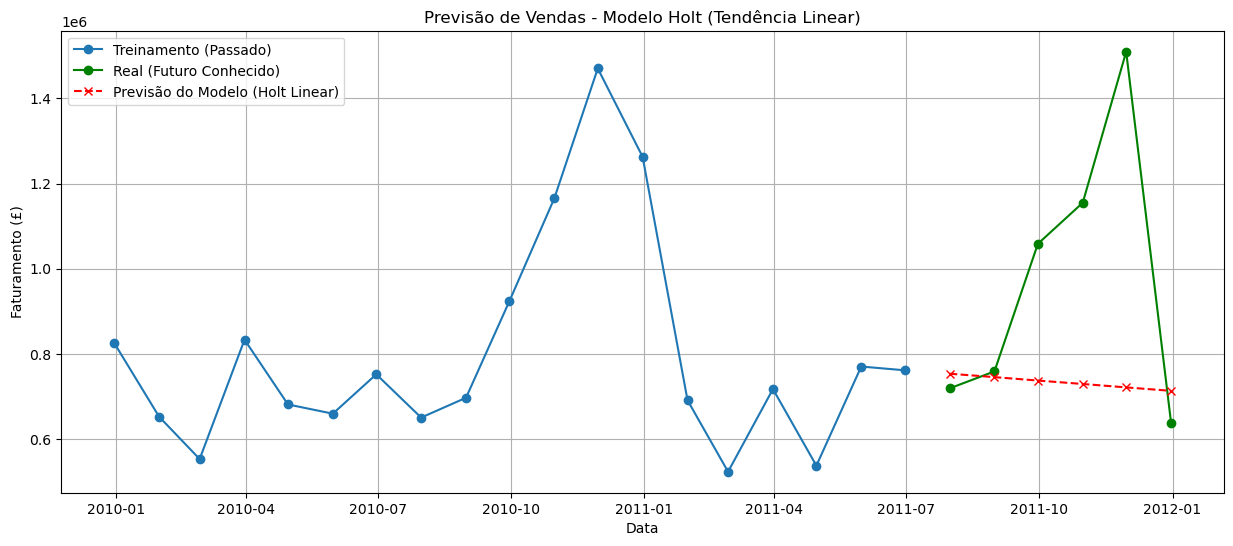

In [19]:
# --- 5. Visualização dos Resultados ---
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['TotalAmount'], label='Treinamento (Passado)', marker='o')
plt.plot(test_data.index, test_data['TotalAmount'], label='Real (Futuro Conhecido)', marker='o', color='green')
plt.plot(previsoes.index, previsoes['Predicao'], label='Previsão do Modelo (Holt Linear)', marker='x', color='red', linestyle='--')

plt.title('Previsão de Vendas - Modelo Holt (Tendência Linear)')
plt.xlabel('Data')
plt.ylabel('Faturamento (£)')
plt.legend()
plt.grid(True)
plt.show()